In [ ]:
import io
import json
import requests
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def crawl_price(stock_id):

  d = datetime.datetime.now()
  url = "https://query1.finance.yahoo.com/v8/finance/chart/"+stock_id+"?period1=0&period2="+str(int(d.timestamp()))+"&interval=1d&events=history&=hP2rOschxO0"

  res = requests.get(url)
  data = json.loads(res.text)
  df = pd.DataFrame(data['chart']['result'][0]['indicators']['quote'][0], index=pd.to_datetime(np.array(data['chart']['result'][0]['timestamp'])*1000*1000*1000))
  return df

In [ ]:
twii = crawl_price("^TWII")

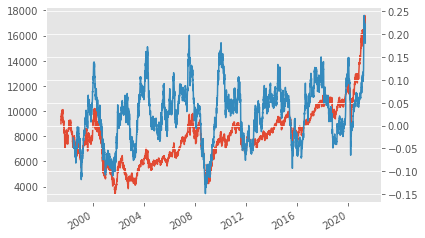

In [ ]:
mean = twii['close'].pct_change().rolling(252).mean()
std = twii['close'].pct_change().rolling(252).std()

sharpe = mean / std

twii.close.plot()
sharpe.plot(secondary_y=True)

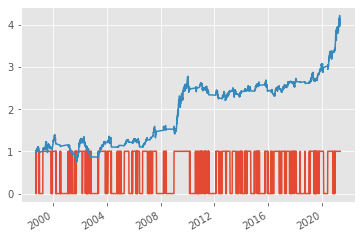

In [ ]:
sr = sharpe
srsma = sr.rolling(60).mean()

# sharpe ratio 的斜率
srsmadiff = srsma.diff()

# 計算買入賣出點
buy = (srsmadiff > 0) & (srsmadiff.shift() < 0)
sell = (srsmadiff < 0) & (srsmadiff.shift() > 0)

# 計算持有時間
hold = pd.Series(np.nan, index=buy.index)
hold[buy] = 1
hold[sell] = 0
hold.ffill(inplace=True)
hold.plot()

# 持有時候的績效
adj = twii['close'][buy.index]
(adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()

In [ ]:
def backtest(a, b, c, d):
    sr = sharpe
    srsma = sr.rolling(a).mean()

    srsmadiff = srsma.diff() * 100
    ub = srsmadiff.quantile(b)
    lb = srsmadiff.quantile(c)
    
    buy = ((srsmadiff.shift(d) < lb) & (srsmadiff > ub))
    sell = ((srsmadiff.shift(d) > ub) & (srsmadiff < lb))

    hold = pd.Series(np.nan, index=buy.index)
    hold[buy] = 1
    hold[sell] = 0

    hold.ffill(inplace=True)
    hold.plot()

    adj = twii['close'][buy.index]
    (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()
    # eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod().plot()
    # hold.plot()
    eq = (adj.pct_change().shift(-1)+1).fillna(1)[hold == 1].cumprod()
    if len(eq) > 0:
        return eq.iloc[-1]
    else:
        return 1

In [ ]:
maxeq = 0

for a in range(100,200,20):
    for b in np.arange(0.3, 0.9, 0.03):
        for c in np.arange(0.3, 0.6, 0.03):
            for d in range(60, 180, 10):
                
                eq = backtest(a,b,c,d)
                
                if maxeq < eq:
                    maxeq = eq
                    print(eq, a,b,c,d)

2.016120628373961 100 0.3 0.3 60
2.0572451256328708 100 0.3 0.3 70
2.6737176342798206 100 0.3 0.3 160
2.710907598322179 100 0.3 0.35999999999999993 160
3.427715779650492 100 0.3 0.44999999999999984 160
3.843818706972501 100 0.3 0.5399999999999998 160
3.9971245948653102 100 0.32999999999999996 0.5399999999999998 160
4.219381688938691 100 0.35999999999999993 0.5399999999999998 160
4.3185970799918705 100 0.35999999999999993 0.5399999999999998 170
4.34610667287573 100 0.6599999999999997 0.32999999999999996 140
4.614930641635172 100 0.6599999999999997 0.35999999999999993 140
5.438174271019897 100 0.6599999999999997 0.35999999999999993 150
5.701236156828396 100 0.6599999999999997 0.4199999999999999 150
6.032979885548914 100 0.6599999999999997 0.44999999999999984 150
6.27311568037834 100 0.6899999999999996 0.44999999999999984 150


6.27311568037834

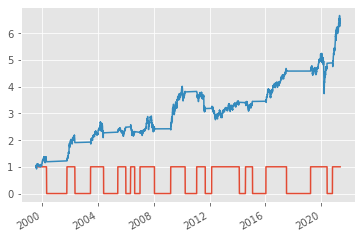

In [ ]:
backtest(100,0.6899999999999996,0.44999999999999984,150)